# Machine Translation: Word-based SMT using IBM1

In this notebook we'll be looking at the IBM Model 1 word alignment method. This will be used to demonstrate the process of training, using expectation maximisation, over a toy dataset. Note that this dataset and presenatation closely follows JM2 Chapter 25, expect for the optimised version which is based on Koehn09 Chapter 4. 

In [59]:
from collections import defaultdict
import itertools

Our dataset will consist of two very short sentence pairs.

In [60]:
bitext = []
bitext.append(("green house".split(), "casa verde".split()))
bitext.append(("the house".split(), "la casa".split()))

Based on the vocabulary items in Spanish and English, we initialise our translation table, *t*, to a uniform distribution. That is, for each word type in English, we set all translations in Spanish to have 1/3.

In [61]:
t0 = defaultdict(dict)
for en_type in "the green house".split():
    for es_type in "la casa verde".split():
        t0[en_type][es_type] = 1.0 / 3
t0

defaultdict(dict,
            {'green': {'casa': 0.3333333333333333,
              'la': 0.3333333333333333,
              'verde': 0.3333333333333333},
             'house': {'casa': 0.3333333333333333,
              'la': 0.3333333333333333,
              'verde': 0.3333333333333333},
             'the': {'casa': 0.3333333333333333,
              'la': 0.3333333333333333,
              'verde': 0.3333333333333333}})

Now for the algorithm itself. Although we tend to merge the expectation and maximisation steps (to save storing big data structures for the expected counts), here we'll do the two separately for clarity. Also, following JM:
 - we won't apply the optimisation for IBM1 which allows us to deal with each position *j* independently. Instead we enumerate the space of all alignments using a cartesian product, see *itertools.product*.
 - we don't consider alignments to the null word

In [62]:
def expectation_step(bitext, translation_probs):
    expectations = []
    for E, F in bitext:
        I = len(E)
        J = len(F)
        # store the unnormalised alignment probabilities
        align = []
        # track the sum of unnormalised alignment probabilities
        Z = 0
        for A in itertools.product(range(I), range(I)):
            pr = 1.0
            for j, aj in enumerate(A):
                pr *= translation_probs[E[aj]][F[j]]
            align.append([A, E, F, pr])
            Z += pr
        # normalise align to produce the alignment probabilities
        for atuple in align:
            atuple[-1] /= Z
        # save the expectations for the M step
        expectations.extend(align)
    return expectations

Let's try running this and see what the expected alignments are

In [63]:
e0 = expectation_step(bitext, t0)
e0

[[(0, 0), ['green', 'house'], ['casa', 'verde'], 0.25],
 [(0, 1), ['green', 'house'], ['casa', 'verde'], 0.25],
 [(1, 0), ['green', 'house'], ['casa', 'verde'], 0.25],
 [(1, 1), ['green', 'house'], ['casa', 'verde'], 0.25],
 [(0, 0), ['the', 'house'], ['la', 'casa'], 0.25],
 [(0, 1), ['the', 'house'], ['la', 'casa'], 0.25],
 [(1, 0), ['the', 'house'], ['la', 'casa'], 0.25],
 [(1, 1), ['the', 'house'], ['la', 'casa'], 0.25]]

We can also view this graphically  

'Prob = 0.2500'

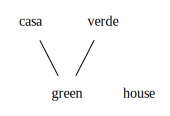

'Prob = 0.2500'

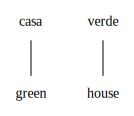

'Prob = 0.2500'

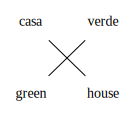

'Prob = 0.2500'

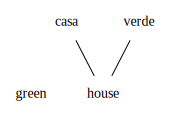

'Prob = 0.2500'

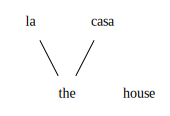

'Prob = 0.2500'

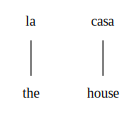

'Prob = 0.2500'

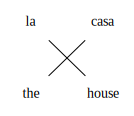

'Prob = 0.2500'

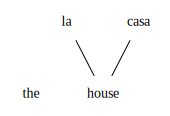

In [64]:
from IPython.display import SVG, display
from nltk.translate import AlignedSent, Alignment

def display_expect(expectations):
    stuff = []
    for A, E, F, prob in expectations:
        if prob > 0.01:
            stuff.append('Prob = %.4f' % prob)
            asent = AlignedSent(F, E, Alignment(list(enumerate(A))))
            stuff.append(SVG(asent._repr_svg_()))
    return display(*stuff)

display_expect(e0)

Note the uniform probabilities for each option (is this a surprise, given our initialisation?) Next up we need to learn the model parameters *t* from these expectations. This is simply a matter of counting occurrences of translation pairs, weighted by their probability. 

In [65]:
def maximization_step(expectations):
    counts = defaultdict(dict)
    for A, E, F, prob in expectations:
        for j, aj in enumerate(A):
            counts[E[aj]].setdefault(F[j], 0.0)
            counts[E[aj]][F[j]] += prob
    
    translations = defaultdict(dict)
    for e, fcounts in counts.items():
        tdict = translations[e]
        total = float(sum(fcounts.values()))
        for f, count in fcounts.items():
            tdict[f] = count / total
    
    return translations

Now we can test this over our expectations. Do you expect this to be uniform like *t0*?

In [66]:
t1 = maximization_step(e0)
t1

defaultdict(dict,
            {'green': {'casa': 0.5, 'verde': 0.5},
             'house': {'casa': 0.5, 'la': 0.25, 'verde': 0.25},
             'the': {'casa': 0.5, 'la': 0.5}})

With working E and M steps, we can now iterate!

In [67]:
t = t0
for step in range(10):
    e = expectation_step(bitext, t)
    t = maximization_step(e)
t

defaultdict(dict,
            {'green': {'casa': 0.09631137780887424,
              'verde': 0.9036886221911259},
             'house': {'casa': 0.982003652902086,
              'la': 0.008998173548957001,
              'verde': 0.008998173548957008},
             'the': {'casa': 0.09631137780887424, 'la': 0.9036886221911258}})

Great, we've learned sensible translations as we hoped.  Try viewing the expectations using *display_expect*, and vary the number of iterations. What happens to the learned parameters? 

# Speeding things up

Recall that the E-step above uses a naive enumeration over all possible alignments, which is going to be woefully slow for anything other than toy data. (What's its computational complexity?) Thankfully a bit of algebraic manipulation of the model1 formulation of $P(A|E,F)$ gives rise to a much simple formulation. Let's give this a try. 

In [68]:
def fast_em(bitext, translation_probs):
    # E-step, computing counts as we go
    counts = defaultdict(dict)
    for E, F in bitext:
        I = len(E)
        J = len(F)
        # each j can be considered independently of the others
        for j in range(J):
            # get the translation probabilities (unnormalised)
            prob_ajs = []
            for aj in range(I):
                prob_ajs.append(translation_probs[E[aj]][F[j]])
            # compute denominator for normalisation
            z = sum(prob_ajs)
            # maintain running counts (this is really part of the M-step)
            for aj in range(I):
                counts[E[aj]].setdefault(F[j], 0.0)
                counts[E[aj]][F[j]] += prob_ajs[aj] / z
    
    # Rest of the M-step to normalise counts
    translations = defaultdict(dict)
    for e, fcounts in counts.items():
        tdict = translations[e]
        total = float(sum(fcounts.values()))
        for f, count in fcounts.items():
            tdict[f] = count / total
    
    return translations

We can test that the parameters learned in each step match what we computed before. What's the time complexity of this algorithm? 

In [69]:
t1p = fast_em(bitext, t0)
t1p

defaultdict(dict,
            {'green': {'casa': 0.5, 'verde': 0.5},
             'house': {'casa': 0.5, 'la': 0.25, 'verde': 0.25},
             'the': {'casa': 0.5, 'la': 0.5}})

In [70]:
t2p = fast_em(bitext, t1)
t2p

defaultdict(dict,
            {'green': {'casa': 0.4285714285714286,
              'verde': 0.5714285714285715},
             'house': {'casa': 0.6000000000000001, 'la': 0.2, 'verde': 0.2},
             'the': {'casa': 0.4285714285714286, 'la': 0.5714285714285715}})

# Alignment models in NLTK

NLTK has a range of translation tools, including the IBM models 1 - 5. These are implemented in their full glory, including the null alignment, and complex optimisation algorithms for models 3 and up. Note that model 4 requires a clustering of the vocabulary, see the [documentation](http://www.nltk.org/api/nltk.translate.html) for details.

In [13]:
from nltk.translate import IBMModel3

bt = [AlignedSent(E,F) for E,F in bitext]
m = IBMModel3(bt, 5)

m.translation_table

defaultdict(<function nltk.translate.ibm_model.<lambda>>,
            {'green': defaultdict(<function nltk.translate.ibm_model.<lambda>>,
                         {None: 1.5000253604969975e-12,
                          'casa': 0.46317208519400105,
                          'verde': 0.9999999999970001}),
             'house': defaultdict(<function nltk.translate.ibm_model.<lambda>>,
                         {None: 0.9999999999969998,
                          'casa': 0.07365582961199793,
                          'la': 3.000050721098189e-12,
                          'verde': 3.000050721098189e-12}),
             'the': defaultdict(<function nltk.translate.ibm_model.<lambda>>,
                         {None: 1.5000253604969975e-12,
                          'casa': 0.46317208519400077,
                          'la': 0.9999999999970001})})

NLTK also includes a small section of the Europarl corpus (about 20K sentence pairs). You might want to apply the alignment models to this larger dataset, although be aware that you will first need to do sentence alignment to discard any sentences that aren't aligned 1:1, e.g., using  [nltk.translate.gale_church](http://www.nltk.org/api/nltk.translate.html#module-nltk.translate.gale_church) to infer the best alignment. You might also want to lower-case the dataset, which keeps the vocabulary small enough for reasonable runtime and robust estimation.

In [115]:
from nltk.corpus.europarl_raw import english, spanish

print english.sents()[0]
print spanish.sents()[0]

[u'Resumption', u'of', u'the', u'session', u'I', u'declare', u'resumed', u'the', u'session', u'of', u'the', u'European', u'Parliament', u'adjourned', u'on', u'Friday', u'17', u'December', u'1999', u',', u'and', u'I', u'would', u'like', u'once', u'again', u'to', u'wish', u'you', u'a', u'happy', u'new', u'year', u'in', u'the', u'hope', u'that', u'you', u'enjoyed', u'a', u'pleasant', u'festive', u'period', u'.']
[u'Reanudaci\xf3n', u'del', u'per\xedodo', u'de', u'sesiones', u'Declaro', u'reanudado', u'el', u'per\xedodo', u'de', u'sesiones', u'del', u'Parlamento', u'Europeo', u',', u'interrumpido', u'el', u'viernes', u'17', u'de', u'diciembre', u'pasado', u',', u'y', u'reitero', u'a', u'Sus', u'Se\xf1or\xedas', u'mi', u'deseo', u'de', u'que', u'hayan', u'tenido', u'unas', u'buenas', u'vacaciones', u'.']
